In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# 1. Model and simulation parameters

The goal of this notebook is to go through the model presented in *colocalisation_model.pdf* and validate item by item with simulation.
Every time we will do this in 2 parts :
* Perfect co-localization validation
* Validation with corrected volume taking into consideration detection range

## Consideration on cell volumes

* First, the model consider cells volume V as a parameter which is more accuretly described as the number of available positions that can be selected at random as a position for a single molecule. This could be 2D or 3D or any dimension, and as long as we consider only **perfect co-localization** this should not influence results. However experimentaly we define a **co-localization range** and thus we need to introduce a distance measure between positions. Experimental co-localization are defined in 3D and so we should consider cells **volumes**, to take this in consideration we correct the volume used in the model to match the number of different positions that would not co-localize according to the co-localization range and voxel size : [**see below**](#volume-correction-for-co-localization-range). In another words, we reduce the number of available positons in the model accordingly with the number of voxels that are scanned, in 3D, withing the co-localization range.

* Secondly, as discussed above, we would like to acess cells volume in pixels, as the number of availbe positions for RNAs. However, **segmentation is performed in 2D**, which raise a serious issue. Expanding the segmentation uniformly on the z axis will include a lot of positions that are experimentally inacessible for single molecules and likely false the results. So we choose to go the opposite way and compute for each (experimental or simulated) cells the average number of singles per plane, and use the 2D segmentation as the number of available positions. For simulation to stay coherent with experiments we simulate enough layers so that the full co-localiation range to be exploited in 3D.

### Cell sections profiles

Here is a typical cell section area profile from our experiments with HelaCells :  
*Notes : voxel size (zyx) is (200,97,97) nm*

![cell_profile](cell_area.png)

For our simulation we will generate different cells with random volumes in credible distribution; let us use this as reference and take a mean value of 48000px for section area.

In [2]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

V_MEAN = 48000
V_STD = 15000
V_MIN = 15000
V_MAX = 90000
volume_distribution = stats.norm(V_MEAN,V_STD)


Text(0, 0.5, 'probability')

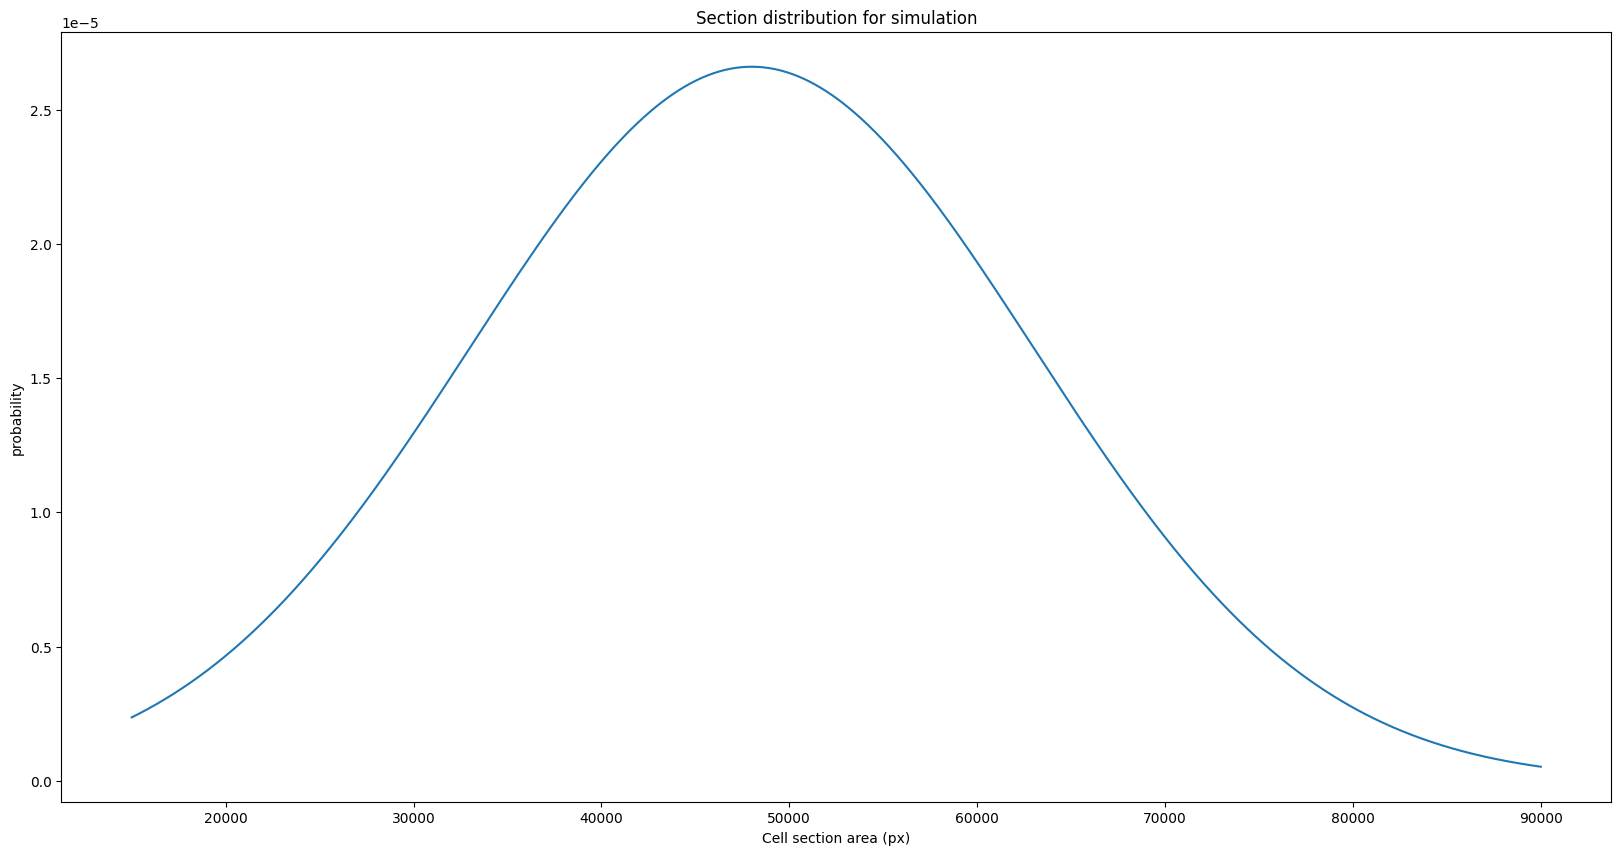

In [3]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca()
X = np.linspace(V_MIN,V_MAX,1000)
Y = volume_distribution.pdf(X)
ax.plot(X,Y)
ax.set_title("Section distribution for simulation")
ax.set_xlabel('Cell section area (px)')
ax.set_ylabel('probability')

### Volume correction for co-localization range

*Note* : In the model corrected_volume is noted *v*.

In [4]:
from scipy.ndimage import distance_transform_edt
def _compute_corrected_positions_number(
    voxel_size : 'tuple[int]',
    colocalisation_distance : int,
    ) :
    """
    This function finds the number of voxels that are scanned with given colocalisation_distance.
    """

    dim = len(voxel_size)

    c = int(
        2*(colocalisation_distance/min(voxel_size))
        )
        
    if c % 2 == 0 : c+=1 #We want c uneven so it is easier to find the center
    center_index = int(
        np.floor(c/2)
    )
    scanned_volume = np.ones((c,)*dim)

    if dim == 3 :
        scanned_volume[center_index,center_index,center_index] = 0
    elif dim == 2 :
        scanned_volume[center_index,center_index,center_index] = 0
    else : raise ValueError(f"Unsupported dimension for voxel size. Must be 2 or 3, it is {dim}")
        
    scanned_volume = distance_transform_edt(scanned_volume, sampling=voxel_size)
    scanned_volume = scanned_volume <= colocalisation_distance
    corrected_positions_number = scanned_volume.sum()

    return corrected_positions_number

In [5]:
coloc_range = 400 #nm
voxel_size = (200,97,97) #nm (zyx)
correction_factor = _compute_corrected_positions_number(voxel_size, colocalisation_distance=coloc_range)
z_range = int(np.floor(coloc_range/voxel_size[0])) # range to considered on z axis

print("voxel_size : ",voxel_size)
print("coloc_range : ",coloc_range)
print("z_range : ",z_range)
print("correction factor for volume : ",correction_factor)

voxel_size :  (200, 97, 97)
coloc_range :  400
z_range :  2
correction factor for volume :  133


### Abundancies per plane

* In our experiments we have typically between 10 to 20 RNA distributions.
* Single molecule number per cell varies between 10 to 250 singles per cells with most distribution below 100 #/cells.
* In the model abundancies are the parameters noted as *k*

In [6]:
abundancies = {
    't0' : 10, # copy per cell : low low
    't1' : 30,
    't2' : 50,
    't3' : 100,
    't4' : 150,
    't5' : 250, # high
    't6' : 500,
    't7' : 1000,
}


In [7]:
distribution_number = {
    't0' : 1 # Number of distribution to simulate with t1 abudancy
    ,'t1' : 1 
    ,'t2' : 1 
    ,'t3' : 1 
    ,'t4' : 1 
    ,'t5' : 1 
    ,'t6' : 1 
    ,'t7' : 1
}

In [8]:
parameters_df = pd.DataFrame(abundancies, index= ['single_per_plane']).T
parameters_df['distribution_number'] = distribution_number.values()
parameters_df

,single_per_plane,distribution_number
t0,10,1
t1,30,1
t2,50,1
t3,100,1
t4,150,1
t5,250,1
t6,500,1
t7,1000,1


# 2. Coordinates generation

Here we generate the random coordinates according to simulation parameters for the rest of the notebook.

In [60]:
V = 40000 #number of available position in a section
simulation_number = 30000

c = round(np.sqrt(V))
print("v : ",V)
print("corresponding square length : ", c)
print("simulation_number : ",simulation_number)


v :  40000
corresponding square length :  200
simulation_number :  30000


Let's recall our set parameters

In [10]:
parameters_df

,single_per_plane,distribution_number
t0,10,1
t1,30,1
t2,50,1
t3,100,1
t4,150,1
t5,250,1
t6,500,1
t7,1000,1


Here we simulate the coordinates, which is the most computing intensive steps.

In [56]:
import cupy as cp
import time as t
cp._default_memory_pool.free_all_blocks()


In [61]:
cp._default_memory_pool.free_all_blocks()
spots_per_simulation = (parameters_df["single_per_plane"] * parameters_df['distribution_number']).sum() * (2*z_range)
total_spot_number = spots_per_simulation * simulation_number
spots_df = pd.DataFrame(columns=['tier','coordinates'])
spots_df['coordinates'] = pd.Series(dtype=object)
distribution_id = 0
max_simulation_id = 0
spots_per_simulation_df = parameters_df['single_per_plane'] * parameters_df['distribution_number']
coords_list = cp.random.random_integers(0,high=c,size=(total_spot_number,2))

#init new lines
new_df = pd.DataFrame(columns=['simulation_id','distribution_id','tier','coordinates','y', 'x'])

#coords as tuple
Y = coords_list[:, 0]
X = coords_list[:, 1]

#Simulation_id
simulation_id = cp.arange(simulation_number)
simulation_id = simulation_id.repeat(spots_per_simulation)
            
#Assigning new line values
new_df = pd.DataFrame({
    'simulation_id' : simulation_id.get(),
    'y' : Y.get(),
    'x' : X.get(),
})
spots_df = pd.concat([
    spots_df,
    new_df
],axis=0)
distribution_id +=1
        
spots_df = spots_df.reset_index(drop=True).reset_index(drop=False, names='spots_id')
spots_df['z'] = (spots_df['spots_id']%(2*z_range+1)).astype(int) * voxel_size[0]
spots_df['y'] = spots_df['y'].astype(int) * voxel_size[1]
spots_df['x'] = spots_df['x'].astype(int) * voxel_size[2]
spots_df['coordinates'] = list(zip(spots_df['z'], spots_df['y'], spots_df['x']))
spots_df

took 0.00010800361633300781 seconds


,spots_id,tier,coordinates,simulation_id,y,x,z
0,0,NaN,"(0, 4947, 11640)",0.0,4947,11640,0
1,1,NaN,"(200, 3783, 9409)",0.0,3783,9409,200
2,2,NaN,"(400, 2619, 15520)",0.0,2619,15520,400
3,3,NaN,"(600, 3880, 4559)",0.0,3880,4559,600
4,4,NaN,"(800, 14647, 14744)",0.0,14647,14744,800
...,...,...,...,...,...,...,...
250799995,250799995,NaN,"(0, 13095, 970)",29999.0,13095,970,0
250799996,250799996,NaN,"(200, 1940, 19109)",29999.0,1940,19109,200
250799997,250799997,NaN,"(400, 17751, 7178)",29999.0,17751,7178,400
250799998,250799998,NaN,"(600, 4462, 16296)",29999.0,4462,16296,600


spots_df = pd.read_feather('./spots_df_backup.feather')
spots_df['coordinates'] = spots_df['coordinates'].apply(tuple)
spots_df

In [ ]:
spots_df.to_feather('./spots_df_backup.feather')

## Accounting for coloc range

In [62]:
coordinates_df = spots_df.loc[spots_df['z'] == z_range*voxel_size[0]].groupby(['simulation_id', 'distribution_id']).agg({
    'coordinates' : list,
    'tier' : 'first'
    })

KeyError: 'distribution_id'

In [ ]:
def create_nearestmodel(spots, n_neighbors= 2, radius= coloc_range) :
    model = NearestNeighbors(n_neighbors=n_neighbors, radius=radius)
    model.fit(spots)
    return model

In [ ]:
coordinates_df['model'] = coordinates_df['coordinates'].apply(create_nearestmodel)
coordinates_df

coordinates  \
simulation_id distribution_id                                                      
0.0           0.0              [(400, 5917, 776), (400, 18818, 14065), (400, ...   
              1.0              [(400, 14356, 9312), (400, 7178, 10670), (400,...   
              2.0              [(400, 10670, 13386), (400, 3783, 15617), (400...   
              3.0              [(400, 9700, 679), (400, 4462, 14162), (400, 1...   
              4.0              [(400, 873, 9312), (400, 16781, 4462), (400, 7...   
...                                                                          ...   
99.0          3.0              [(400, 10379, 97), (400, 12125, 582), (400, 17...   
              4.0              [(400, 5917, 4268), (400, 8051, 14162), (400, ...   
              5.0              [(400, 8536, 15617), (400, 7954, 6305), (400, ...   
              6.0              [(400, 2910, 3686), (400, 11058, 14065), (400,...   
              7.0              [(400, 8633, 6887), (400, 1940, 8536), (400, 1...   

                              tier  \
simulation_id distribution_id        
0.0           0.0               t0   
              1.0               t1   
              2.0               t2   
              3.0               t3   
              4.0               t4   
...                            ...   
99.0          3.0               t3   
              4.0               t4   
              5.0               t5   
              6.0               t6   
              7.0               t7   

                                                                     model  
simulation_id distribution_id                                               
0.0           0.0              NearestNeighbors(n_neighbors=2, radius=400)  
              1.0              NearestNeighbors(n_neighbors=2, radius=400)  
              2.0              NearestNeighbors(n_neighbors=2, radius=400)  
              3.0              NearestNeighbors(n_neighbors=2, radius=400)  
              4.0              NearestNeighbors(n_neighbors=2, radius=400)  
...                                                                    ...  
99.0          3.0              NearestNeighbors(n_neighbors=2, radius=400)  
              4.0              NearestNeighbors(n_neighbors=2, radius=400)  
              5.0              NearestNeighbors(n_neighbors=2, radius=400)  
              6.0              NearestNeighbors(n_neighbors=2, radius=400)  
              7.0              NearestNeighbors(n_neighbors=2, radius=400)  

[800 rows x 3 columns]

In [ ]:
tier_list = list(coordinates_df['tier'].unique())

In [ ]:
spots_df

,spots_id,tier,coordinates,simulation_id,distribution_id,y,x,z
0,0,t0,"(0, 16490, 12319)",0.0,0.0,16490,12319,0
1,1,t0,"(200, 9894, 5141)",0.0,0.0,9894,5141,200
2,2,t0,"(400, 5917, 776)",0.0,0.0,5917,776,400
3,3,t0,"(600, 1455, 291)",0.0,0.0,1455,291,600
4,4,t0,"(800, 3395, 15714)",0.0,0.0,3395,15714,800
...,...,...,...,...,...,...,...,...
1044995,1044995,t7,"(0, 12416, 11058)",99.0,7.0,12416,11058,0
1044996,1044996,t7,"(200, 10185, 11349)",99.0,7.0,10185,11349,200
1044997,1044997,t7,"(400, 16005, 5238)",99.0,7.0,16005,5238,400
1044998,1044998,t7,"(600, 17848, 5335)",99.0,7.0,17848,5335,600


In [ ]:
columns=[
    'simulation_id',
    'distribution_id',
    'tier',
] + tier_list

truth_df = pd.DataFrame(
    columns=columns,
    index= pd.Index(spots_df.loc[spots_df['z'] == z_range*voxel_size[0]]['spots_id'])
)

truth_df['simulation_id'] = spots_df['simulation_id']
truth_df['distribution_id'] = spots_df['distribution_id']
truth_df['tier'] = spots_df['tier']
truth_df['coordinates'] = spots_df['coordinates']
truth_df

,simulation_id,distribution_id,tier,t0,t1,t2,t3,t4,t5,t6,t7,coordinates
spots_id,,,,,,,,,,,,
2,0.0,0.0,t0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(400, 5917, 776)"
7,0.0,0.0,t0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(400, 18818, 14065)"
12,0.0,0.0,t0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(400, 7566, 16587)"
17,0.0,0.0,t0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(400, 388, 10476)"
22,0.0,0.0,t0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(400, 97, 12998)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1044977,99.0,7.0,t7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(400, 0, 9021)"
1044982,99.0,7.0,t7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(400, 19012, 13095)"
1044987,99.0,7.0,t7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"(400, 17266, 11737)"


In [ ]:
coordinates_df = coordinates_df.reset_index(drop=False)
coordinates_df = coordinates_df.set_index(['simulation_id', 'tier'], verify_integrity=True)
coordinates_df

distribution_id  \
simulation_id tier                    
0.0           t0                0.0   
              t1                1.0   
              t2                2.0   
              t3                3.0   
              t4                4.0   
...                             ...   
99.0          t3                3.0   
              t4                4.0   
              t5                5.0   
              t6                6.0   
              t7                7.0   

                                                          coordinates  \
simulation_id tier                                                      
0.0           t0    [(400, 5917, 776), (400, 18818, 14065), (400, ...   
              t1    [(400, 14356, 9312), (400, 7178, 10670), (400,...   
              t2    [(400, 10670, 13386), (400, 3783, 15617), (400...   
              t3    [(400, 9700, 679), (400, 4462, 14162), (400, 1...   
              t4    [(400, 873, 9312), (400, 16781, 4462), (400, 7...   
...                                                               ...   
99.0          t3    [(400, 10379, 97), (400, 12125, 582), (400, 17...   
              t4    [(400, 5917, 4268), (400, 8051, 14162), (400, ...   
              t5    [(400, 8536, 15617), (400, 7954, 6305), (400, ...   
              t6    [(400, 2910, 3686), (400, 11058, 14065), (400,...   
              t7    [(400, 8633, 6887), (400, 1940, 8536), (400, 1...   

                                                          model  
simulation_id tier                                               
0.0           t0    NearestNeighbors(n_neighbors=2, radius=400)  
              t1    NearestNeighbors(n_neighbors=2, radius=400)  
              t2    NearestNeighbors(n_neighbors=2, radius=400)  
              t3    NearestNeighbors(n_neighbors=2, radius=400)  
              t4    NearestNeighbors(n_neighbors=2, radius=400)  
...                                                         ...  
99.0          t3    NearestNeighbors(n_neighbors=2, radius=400)  
              t4    NearestNeighbors(n_neighbors=2, radius=400)  
              t5    NearestNeighbors(n_neighbors=2, radius=400)  
              t6    NearestNeighbors(n_neighbors=2, radius=400)  
              t7    NearestNeighbors(n_neighbors=2, radius=400)  

[800 rows x 3 columns]

In [ ]:
for tier in tier_list :
    print("tier : ", tier)
    for simulation in tqdm(range(simulation_number)) :
        model : NearestNeighbors = coordinates_df.at[(simulation,tier),'model']
        spots = spots_df.loc[(spots_df['simulation_id'] == simulation)&(spots_df['z'] == z_range*voxel_size[0])]['coordinates']
        distances,_ = model.kneighbors(list(spots))
        truth_df.loc[truth_df['simulation_id'] == simulation,[tier]] = ((distances <= coloc_range).sum(axis=1)).astype(int)

    truth_df.loc[truth_df['tier'] == tier,[tier]] = (truth_df.loc[truth_df['tier'] == tier,[tier]] == 2).astype(int)

for tier in tier_list :
    truth_df[tier] = truth_df[tier].astype(bool)

truth_df.reset_index(drop=False).to_feather('./truth_df_backup.feather')
truth_df

tier :  t0


100%|██████████| 100/100 [00:00<00:00, 275.11it/s]


tier :  t1


100%|██████████| 100/100 [00:00<00:00, 252.21it/s]


tier :  t2


100%|██████████| 100/100 [00:00<00:00, 244.99it/s]


tier :  t3


100%|██████████| 100/100 [00:00<00:00, 248.06it/s]


tier :  t4


100%|██████████| 100/100 [00:00<00:00, 251.66it/s]


tier :  t5


100%|██████████| 100/100 [00:00<00:00, 247.27it/s]


tier :  t6


100%|██████████| 100/100 [00:00<00:00, 241.64it/s]


tier :  t7


100%|██████████| 100/100 [00:00<00:00, 222.85it/s]


,simulation_id,distribution_id,tier,t0,t1,t2,t3,t4,t5,t6,t7,coordinates
spots_id,,,,,,,,,,,,
2,0.0,0.0,t0,False,False,False,False,False,True,False,True,"(400, 5917, 776)"
7,0.0,0.0,t0,False,False,False,False,False,True,True,True,"(400, 18818, 14065)"
12,0.0,0.0,t0,False,False,False,False,False,False,False,False,"(400, 7566, 16587)"
17,0.0,0.0,t0,False,False,False,False,False,False,False,True,"(400, 388, 10476)"
22,0.0,0.0,t0,False,False,False,False,False,False,False,True,"(400, 97, 12998)"
...,...,...,...,...,...,...,...,...,...,...,...,...
1044977,99.0,7.0,t7,False,False,False,False,False,False,False,True,"(400, 0, 9021)"
1044982,99.0,7.0,t7,False,False,False,False,False,True,True,True,"(400, 19012, 13095)"
1044987,99.0,7.0,t7,False,False,True,False,False,False,True,True,"(400, 17266, 11737)"


# 3. Unique distribution validation

In this part we will validate modelisation for voxel occupancy of single molecules and self co-localization results.

## Perfect co-localisation

### Voxel_occupancy

In [ ]:
coordinates_df['position_number'] = V
coordinates_df

distribution_id  \
simulation_id tier                    
0.0           t0                0.0   
              t1                1.0   
              t2                2.0   
              t3                3.0   
              t4                4.0   
...                             ...   
99.0          t3                3.0   
              t4                4.0   
              t5                5.0   
              t6                6.0   
              t7                7.0   

                                                          coordinates  \
simulation_id tier                                                      
0.0           t0    [(400, 5917, 776), (400, 18818, 14065), (400, ...   
              t1    [(400, 14356, 9312), (400, 7178, 10670), (400,...   
              t2    [(400, 10670, 13386), (400, 3783, 15617), (400...   
              t3    [(400, 9700, 679), (400, 4462, 14162), (400, 1...   
              t4    [(400, 873, 9312), (400, 16781, 4462), (400, 7...   
...                                                               ...   
99.0          t3    [(400, 10379, 97), (400, 12125, 582), (400, 17...   
              t4    [(400, 5917, 4268), (400, 8051, 14162), (400, ...   
              t5    [(400, 8536, 15617), (400, 7954, 6305), (400, ...   
              t6    [(400, 2910, 3686), (400, 11058, 14065), (400,...   
              t7    [(400, 8633, 6887), (400, 1940, 8536), (400, 1...   

                                                          model  \
simulation_id tier                                                
0.0           t0    NearestNeighbors(n_neighbors=2, radius=400)   
              t1    NearestNeighbors(n_neighbors=2, radius=400)   
              t2    NearestNeighbors(n_neighbors=2, radius=400)   
              t3    NearestNeighbors(n_neighbors=2, radius=400)   
              t4    NearestNeighbors(n_neighbors=2, radius=400)   
...                                                         ...   
99.0          t3    NearestNeighbors(n_neighbors=2, radius=400)   
              t4    NearestNeighbors(n_neighbors=2, radius=400)   
              t5    NearestNeighbors(n_neighbors=2, radius=400)   
              t6    NearestNeighbors(n_neighbors=2, radius=400)   
              t7    NearestNeighbors(n_neighbors=2, radius=400)   

                    position_number  
simulation_id tier                   
0.0           t0              40000  
              t1              40000  
              t2              40000  
              t3              40000  
              t4              40000  
...                             ...  
99.0          t3              40000  
              t4              40000  
              t5              40000  
              t6              40000  
              t7              40000  

[800 rows x 4 columns]

#### Simulation

In [ ]:
coordinates_df['voxel_occupancy'] = coordinates_df['coordinates'].apply(lambda x : len(pd.unique(x)))
coordinates_df['abundancy'] = coordinates_df['coordinates'].apply(lambda x : len(x))
coordinates_df = coordinates_df.reset_index(drop=False)
coordinates_df

,simulation_id,tier,distribution_id,coordinates,model,position_number,voxel_occupancy,abundancy
0,0.0,t0,0.0,"[(400, 5917, 776), (400, 18818, 14065), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,10,10
1,0.0,t1,1.0,"[(400, 14356, 9312), (400, 7178, 10670), (400,...","NearestNeighbors(n_neighbors=2, radius=400)",40000,30,30
2,0.0,t2,2.0,"[(400, 10670, 13386), (400, 3783, 15617), (400...","NearestNeighbors(n_neighbors=2, radius=400)",40000,50,50
3,0.0,t3,3.0,"[(400, 9700, 679), (400, 4462, 14162), (400, 1...","NearestNeighbors(n_neighbors=2, radius=400)",40000,100,100
4,0.0,t4,4.0,"[(400, 873, 9312), (400, 16781, 4462), (400, 7...","NearestNeighbors(n_neighbors=2, radius=400)",40000,150,150
...,...,...,...,...,...,...,...,...
795,99.0,t3,3.0,"[(400, 10379, 97), (400, 12125, 582), (400, 17...","NearestNeighbors(n_neighbors=2, radius=400)",40000,100,100
796,99.0,t4,4.0,"[(400, 5917, 4268), (400, 8051, 14162), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,150,150
797,99.0,t5,5.0,"[(400, 8536, 15617), (400, 7954, 6305), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,250,250
798,99.0,t6,6.0,"[(400, 2910, 3686), (400, 11058, 14065), (400,...","NearestNeighbors(n_neighbors=2, radius=400)",40000,496,500


#### Model
According to our model we have :  

$p$ & $q$ definitions :
* $p = 1-(1-\frac{1}{v})^k$
* $q = 1 -2(1-\frac{1}{v})^k + (1-\frac{2}{v})^k$
* $q-p^2 = (1-\frac{2}{v})^k + (1-\frac{1}{v})^{2k}$

mean and standard deviation :
* $\mu_{up} = v(1-(1-\frac{1}{v})^k) = vp$
* $\sigma_{up} = \sqrt{vp(1-p) + v(v-1)[q-p^2]}$

In [ ]:
pf_model_df = coordinates_df.drop_duplicates(subset='tier').drop(columns=['voxel_occupancy','simulation_id'])
pf_model_df['p'] = (1-(1-(1/pf_model_df['position_number'])).pow(pf_model_df['abundancy']))
pf_model_df['q'] = 1-2*(1-(1/pf_model_df['position_number'])).pow(pf_model_df['abundancy'])+(1-(2/pf_model_df['position_number'])).pow(pf_model_df['abundancy'])

v = pf_model_df['position_number']
p = pf_model_df['p']
q = pf_model_df['q']

pf_model_df['voxel_occupancy_mean'] = v*p
pf_model_df['voxel_occupancy_std'] = (v*p*(1-p) + v*(v-1)*(q-p.pow(2))).apply(np.sqrt)
pf_model_df

,tier,distribution_id,coordinates,model,position_number,abundancy,p,q,voxel_occupancy_mean,voxel_occupancy_std
0,t0,0.0,"[(400, 5917, 776), (400, 18818, 14065), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,10,0.000250,5.623875e-08,9.998875,0.033563
1,t1,1.0,"[(400, 14356, 9312), (400, 7178, 10670), (400,...","NearestNeighbors(n_neighbors=2, radius=400)",40000,30,0.000750,5.433695e-07,29.989128,0.104246
2,t2,2.0,"[(400, 10670, 13386), (400, 3783, 15617), (400...","NearestNeighbors(n_neighbors=2, radius=400)",40000,50,0.001249,1.529414e-06,49.969387,0.174848
3,t3,3.0,"[(400, 9700, 679), (400, 4462, 14162), (400, 1...","NearestNeighbors(n_neighbors=2, radius=400)",40000,100,0.002497,6.172362e-06,99.876351,0.351084
4,t4,4.0,"[(400, 873, 9312), (400, 16781, 4462), (400, 7...","NearestNeighbors(n_neighbors=2, radius=400)",40000,150,0.003743,1.391718e-05,149.720969,0.526951
5,t5,5.0,"[(400, 17266, 8633), (400, 10961, 14647), (400...","NearestNeighbors(n_neighbors=2, radius=400)",40000,250,0.006231,3.866590e-05,249.223481,0.877582
6,t6,6.0,"[(400, 3977, 15132), (400, 10185, 2910), (400,...","NearestNeighbors(n_neighbors=2, radius=400)",40000,500,0.012422,1.540101e-04,496.894153,1.747777
7,t7,7.0,"[(400, 16005, 6402), (400, 2716, 5141), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,1000,0.024690,6.090209e-04,987.615710,3.461061


#### Plots

/tmp/ipykernel_16544/1951150141.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_occ,max_occ)
/tmp/ipykernel_16544/1951150141.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_occ,max_occ)


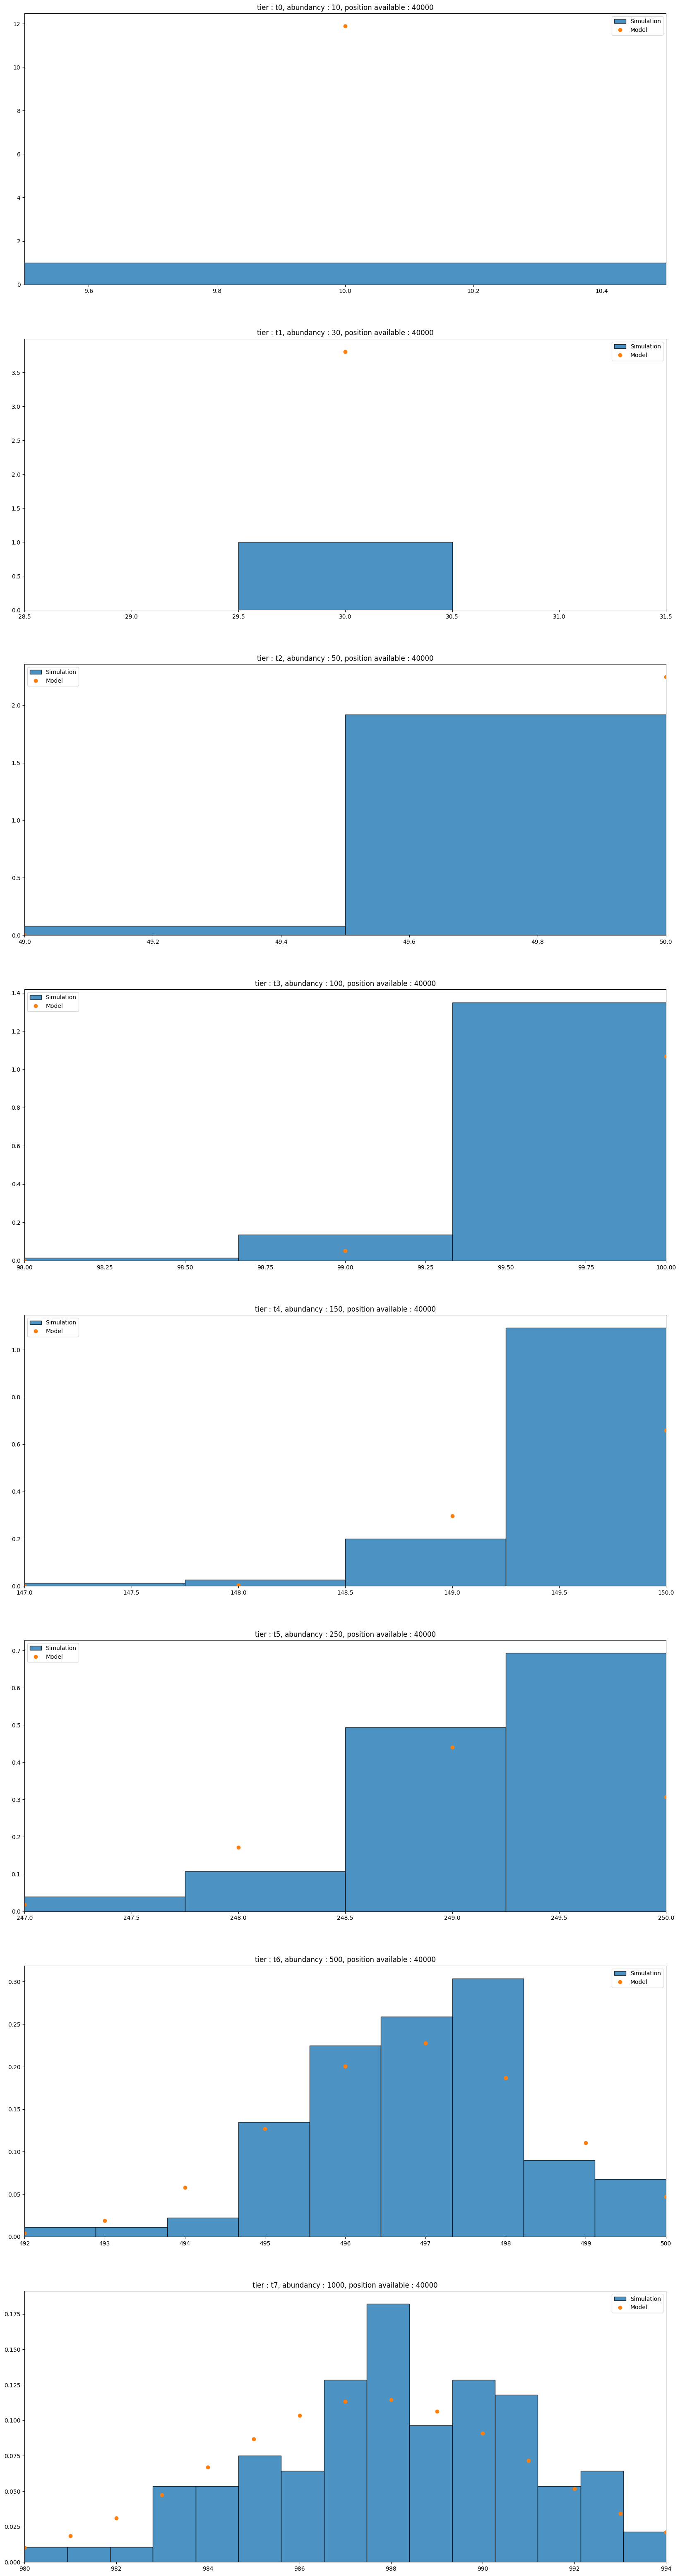

In [ ]:
tier_number = len(pf_model_df)

fig = plt.figure(figsize=(20,tier_number*10))
axes = fig.subplots(tier_number,1)
for index,ax in zip(pf_model_df.index,axes) :
    
    #Pool data
    tier, mean, std, abundacy = pf_model_df.loc[index, ['tier', 'voxel_occupancy_mean', 'voxel_occupancy_std', 'abundancy']]
    voxel_occupancy = (coordinates_df.loc[coordinates_df['tier'] == tier].loc[:,["voxel_occupancy"]]).squeeze()
    max_occ, min_occ = voxel_occupancy.max(), voxel_occupancy.min()
    simulation_number = len(voxel_occupancy)

    #Simulation results histogram
    count,bins,_ =ax.hist(voxel_occupancy, max_occ - min_occ+1, density=True, edgecolor= 'black', alpha= 0.8,label="Simulation", align='mid')
    count /= simulation_number

    # Normal law from model
    normal_law = stats.norm(mean,std)
    X = np.linspace(min_occ, max_occ, max_occ-min_occ+1)
    Y = normal_law.pdf(X)

    ax.set_title(f"tier : {tier}, abundancy : {abundacy}, position available : {V}")

    ax.plot(X,Y,'o',label='Model')
    ax.set_xlim(min_occ,max_occ)
    ax.legend()

### Self co-localization

#### simulation

In [ ]:
coordinates_df['self_colocalization'] = coordinates_df['abundancy'] - coordinates_df['voxel_occupancy']
coordinates_df

,simulation_id,tier,distribution_id,coordinates,model,position_number,voxel_occupancy,abundancy,self_colocalization
0,0.0,t0,0.0,"[(400, 5917, 776), (400, 18818, 14065), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,10,10,0
1,0.0,t1,1.0,"[(400, 14356, 9312), (400, 7178, 10670), (400,...","NearestNeighbors(n_neighbors=2, radius=400)",40000,30,30,0
2,0.0,t2,2.0,"[(400, 10670, 13386), (400, 3783, 15617), (400...","NearestNeighbors(n_neighbors=2, radius=400)",40000,50,50,0
3,0.0,t3,3.0,"[(400, 9700, 679), (400, 4462, 14162), (400, 1...","NearestNeighbors(n_neighbors=2, radius=400)",40000,100,100,0
4,0.0,t4,4.0,"[(400, 873, 9312), (400, 16781, 4462), (400, 7...","NearestNeighbors(n_neighbors=2, radius=400)",40000,150,150,0
...,...,...,...,...,...,...,...,...,...
795,99.0,t3,3.0,"[(400, 10379, 97), (400, 12125, 582), (400, 17...","NearestNeighbors(n_neighbors=2, radius=400)",40000,100,100,0
796,99.0,t4,4.0,"[(400, 5917, 4268), (400, 8051, 14162), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,150,150,0
797,99.0,t5,5.0,"[(400, 8536, 15617), (400, 7954, 6305), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,250,250,0
798,99.0,t6,6.0,"[(400, 2910, 3686), (400, 11058, 14065), (400,...","NearestNeighbors(n_neighbors=2, radius=400)",40000,496,500,4


#### model

In [ ]:
pf_model_df['self_colocalization_mean'] = pf_model_df['abundancy'] - pf_model_df['voxel_occupancy_mean']
pf_model_df

,tier,distribution_id,coordinates,model,position_number,abundancy,p,q,voxel_occupancy_mean,voxel_occupancy_std,self_colocalization_mean
0,t0,0.0,"[(400, 5917, 776), (400, 18818, 14065), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,10,0.000250,5.623875e-08,9.998875,0.033563,0.001125
1,t1,1.0,"[(400, 14356, 9312), (400, 7178, 10670), (400,...","NearestNeighbors(n_neighbors=2, radius=400)",40000,30,0.000750,5.433695e-07,29.989128,0.104246,0.010872
2,t2,2.0,"[(400, 10670, 13386), (400, 3783, 15617), (400...","NearestNeighbors(n_neighbors=2, radius=400)",40000,50,0.001249,1.529414e-06,49.969387,0.174848,0.030613
3,t3,3.0,"[(400, 9700, 679), (400, 4462, 14162), (400, 1...","NearestNeighbors(n_neighbors=2, radius=400)",40000,100,0.002497,6.172362e-06,99.876351,0.351084,0.123649
4,t4,4.0,"[(400, 873, 9312), (400, 16781, 4462), (400, 7...","NearestNeighbors(n_neighbors=2, radius=400)",40000,150,0.003743,1.391718e-05,149.720969,0.526951,0.279031
5,t5,5.0,"[(400, 17266, 8633), (400, 10961, 14647), (400...","NearestNeighbors(n_neighbors=2, radius=400)",40000,250,0.006231,3.866590e-05,249.223481,0.877582,0.776519
6,t6,6.0,"[(400, 3977, 15132), (400, 10185, 2910), (400,...","NearestNeighbors(n_neighbors=2, radius=400)",40000,500,0.012422,1.540101e-04,496.894153,1.747777,3.105847
7,t7,7.0,"[(400, 16005, 6402), (400, 2716, 5141), (400, ...","NearestNeighbors(n_neighbors=2, radius=400)",40000,1000,0.024690,6.090209e-04,987.615710,3.461061,12.384290


#### Plots

/tmp/ipykernel_16544/3636015771.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_occ,max_occ)
/tmp/ipykernel_16544/3636015771.py:25: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_occ,max_occ)


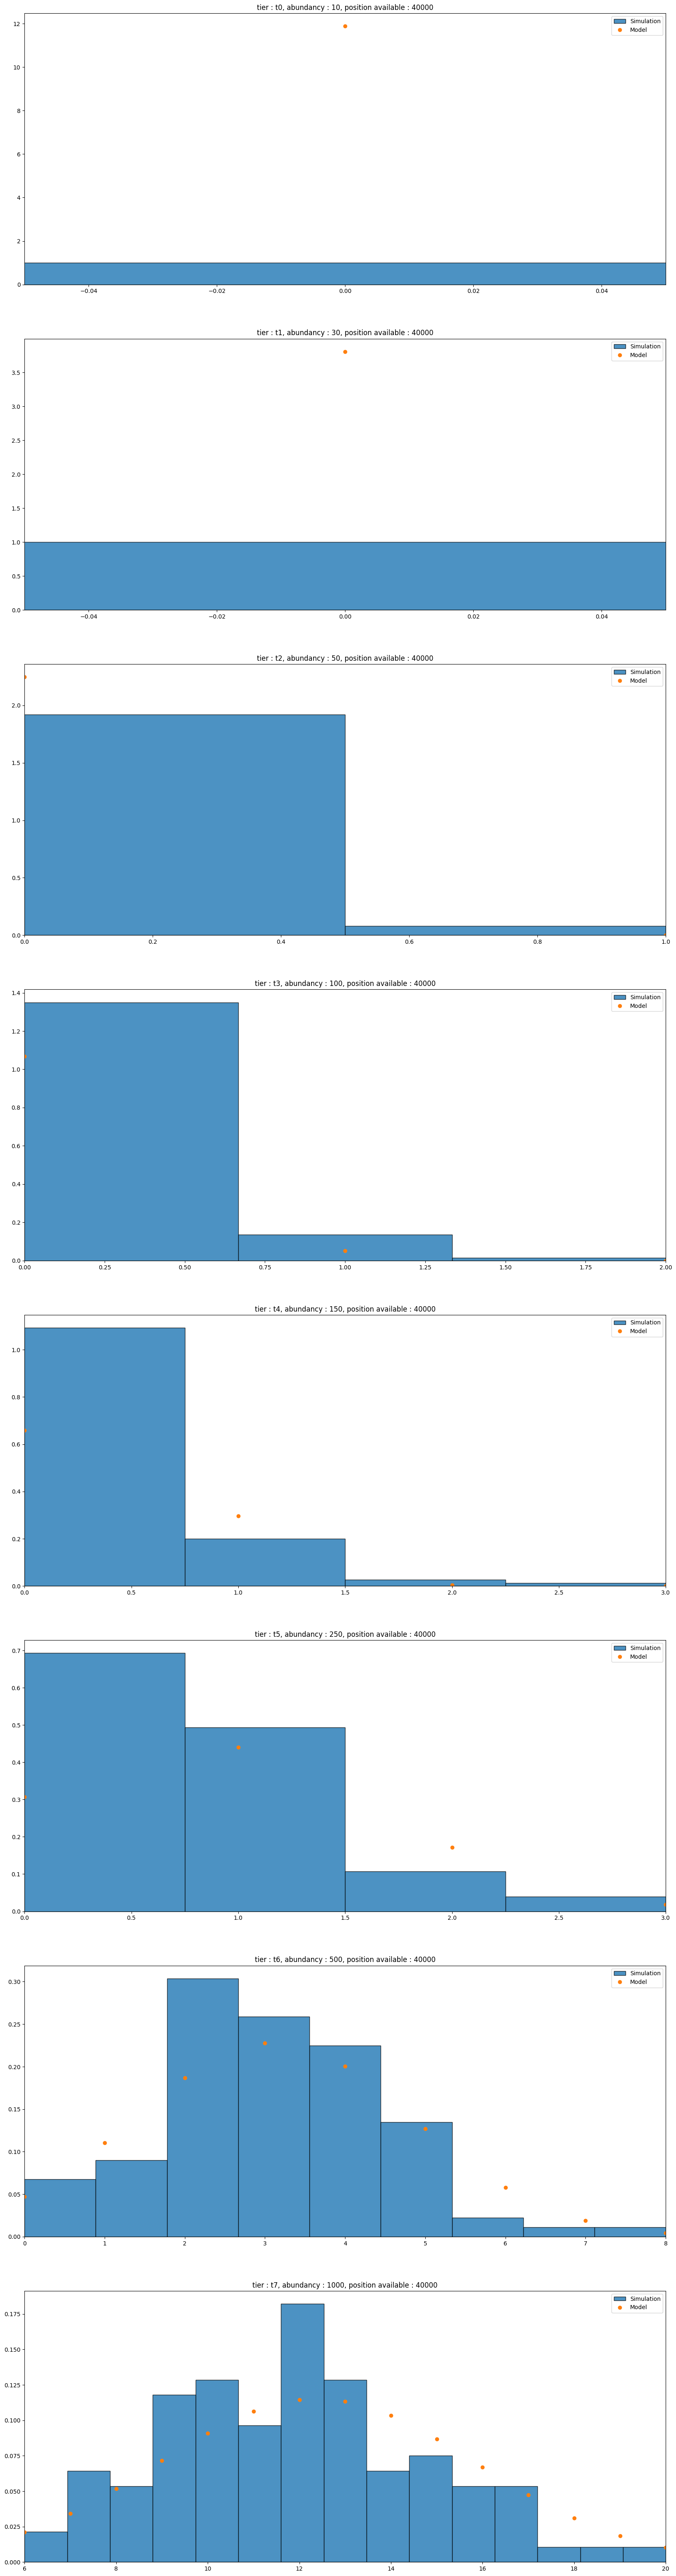

In [ ]:
tier_number = len(pf_model_df)

fig = plt.figure(figsize=(20,tier_number*10))
axes = fig.subplots(tier_number,1)
for index,ax in zip(pf_model_df.index,axes) :
    
    #Pool data
    tier, mean, std, abundacy = pf_model_df.loc[index, ['tier', 'self_colocalization_mean', 'voxel_occupancy_std', 'abundancy']]
    self_colocalization = (coordinates_df.loc[coordinates_df['tier'] == tier].loc[:,["self_colocalization"]]).squeeze()
    max_occ, min_occ = self_colocalization.max(), self_colocalization.min()
    simulation_number = len(self_colocalization)

    #Simulation results histogram
    count,bins,_ =ax.hist(self_colocalization, max_occ - min_occ+1, density=True, edgecolor= 'black', alpha= 0.8,label="Simulation", align='mid')
    count /= simulation_number

    # Normal law from model
    normal_law = stats.norm(mean,std)
    X = np.linspace(min_occ, max_occ, max_occ-min_occ+1)
    Y = normal_law.pdf(X)

    ax.set_title(f"tier : {tier}, abundancy : {abundacy}, position available : {V}")

    ax.plot(X,Y,'o',label='Model')
    ax.set_xlim(min_occ,max_occ)
    ax.legend()